In [91]:
import time, os, pickle
import joblib
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import plotly.graph_objects as go
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE


from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler,RobustScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold,mutual_info_classif, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
)
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from operator import itemgetter
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

from sklearn.feature_selection import RFECV


#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Allow long lines

In [92]:
# Specify the path to the CSV file in the parent directory
file_path = "../Dataset/pd_speech_features/pd_speech_features.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=',',skiprows=1)

In [93]:
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_

# Filtrar o Dataset para apenas apresentar dados do Sexo Feminino e sexo Masculino

In [94]:
female_df = df[df['gender'] == 0]
male_df = df[df['gender'] == 1]
female_df.shape
male_df.shape

(390, 755)

# Drop da Coluna de Id

In [95]:
female_df = female_df.drop("id", axis=1)
male_df = male_df.drop("id", axis=1)

# Divisão entre features e label

In [96]:
X_female = female_df.drop('class', axis=1)  # Features
y_female = female_df['class']  # Target variable
X_male = male_df.drop('class', axis=1)  # Features
y_male = male_df['class']  # Target variable

# SMOTE

In [97]:
smote_female = SMOTE(sampling_strategy='auto', random_state=42)
X_female_smote, y_female_smote = smote_female.fit_resample(X_female, y_female)

smote_male = SMOTE(sampling_strategy='auto', random_state=42)
X_male_smote, y_male_smote = smote_male.fit_resample(X_male, y_male)

In [98]:
unique, counts = np.unique(y_female, return_counts=True)
original_class_distribution = dict(zip(unique, counts))
unique, counts = np.unique(y_female_smote, return_counts=True)
resampled_class_distribution = dict(zip(unique, counts))

print("Original class distribution:", original_class_distribution)
print("Resampled class distribution:", resampled_class_distribution)

Original class distribution: {0: 123, 1: 243}
Resampled class distribution: {0: 243, 1: 243}


In [99]:
unique, counts = np.unique(y_male, return_counts=True)
original_class_distribution = dict(zip(unique, counts))
unique, counts = np.unique(y_male_smote, return_counts=True)
resampled_class_distribution = dict(zip(unique, counts))

print("Original class distribution:", original_class_distribution)
print("Resampled class distribution:", resampled_class_distribution)

Original class distribution: {0: 69, 1: 321}
Resampled class distribution: {0: 321, 1: 321}


# Normalização dos dois Datasets (Feminino e Masculino)

In [100]:
features = X_female_smote.columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the features
X_female_smote_scaled = pd.DataFrame(scaler.fit_transform(X_female_smote[features]), columns=features)

In [101]:
features = X_male_smote.columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the features
X_male_smote_scaled = pd.DataFrame(scaler.fit_transform(X_male_smote[features]), columns=features)

# Correlation

In [102]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything else
# without any further insight.

def correlation(dataset, threshold):
    
    # create a set where I will store the names of correlated columns
    col_corr = set()
    
    # create the correlation matrix
    corr_matrix = dataset.corr()
    
    # for each feature in the dataset (columns of the correlation matrix)
    for i in range(len(corr_matrix.columns)):
        
        # check with other features
        for j in range(i):
            
            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                
                # get the name of the correlated feature
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

In [103]:
corr_features_female = correlation(X_female_smote_scaled, 0.8)
corr_features_male = correlation(X_male_smote_scaled, 0.8)
print(len(set(corr_features_female)))
print(len(set(corr_features_male)))

0.9999460815644424 numPeriodsPulses numPulses
0.9027891354450992 meanPeriodPulses numPulses
0.9026458394763934 meanPeriodPulses numPeriodsPulses
0.9561477902685724 locAbsJitter locPctJitter
0.9587158530168505 rapJitter locPctJitter
0.9625658640253487 rapJitter locAbsJitter
0.9660429384212299 ppq5Jitter locPctJitter
0.951454143205803 ppq5Jitter locAbsJitter
0.9699975826011277 ppq5Jitter rapJitter
0.9587320691814611 ddpJitter locPctJitter
0.9626363370250992 ddpJitter locAbsJitter
0.9999941872028469 ddpJitter rapJitter
0.9700416050994086 ddpJitter ppq5Jitter
0.9959380227759249 locDbShimmer locShimmer
0.982907590008753 apq3Shimmer locShimmer
0.9767030438081709 apq3Shimmer locDbShimmer
0.9841284841711554 apq5Shimmer locShimmer
0.9773652427312904 apq5Shimmer locDbShimmer
0.9675872869069989 apq5Shimmer apq3Shimmer
0.9145265491337877 apq11Shimmer locShimmer
0.9156226070834663 apq11Shimmer locDbShimmer
0.8663046155327179 apq11Shimmer apq3Shimmer
0.9285285880029288 apq11Shimmer apq5Shimmer
0.982

0.9885422854219956 app_entropy_shannon_10_coef app_entropy_shannon_1_coef
0.9913528145211997 app_entropy_shannon_10_coef app_entropy_shannon_2_coef
0.9944613129895203 app_entropy_shannon_10_coef app_entropy_shannon_3_coef
0.9974277862212348 app_entropy_shannon_10_coef app_entropy_shannon_4_coef
0.9991238876089058 app_entropy_shannon_10_coef app_entropy_shannon_5_coef
0.9998184259459747 app_entropy_shannon_10_coef app_entropy_shannon_6_coef
0.9999159949494194 app_entropy_shannon_10_coef app_entropy_shannon_7_coef
0.9999964501989091 app_entropy_shannon_10_coef app_entropy_shannon_8_coef
0.9999981150819496 app_entropy_shannon_10_coef app_entropy_shannon_9_coef
0.8199456805779047 app_entropy_log_1_coef numPulses
0.8196185208944009 app_entropy_log_1_coef numPeriodsPulses
0.8442793069060117 app_entropy_log_1_coef app_entropy_shannon_1_coef
0.843214638971684 app_entropy_log_1_coef app_entropy_shannon_2_coef
0.8401317943524736 app_entropy_log_1_coef app_entropy_shannon_3_coef
0.834282758877987

0.9714568324300948 det_LT_entropy_log_1_coef det_entropy_log_1_coef
0.9390188257444958 det_LT_entropy_log_1_coef det_entropy_log_2_coef
0.8521188169439345 det_LT_entropy_log_1_coef det_entropy_log_3_coef
0.8174143488002062 det_LT_entropy_log_1_coef det_LT_entropy_shannon_1_coef
0.8161934376410278 det_LT_entropy_log_1_coef det_LT_entropy_shannon_2_coef
0.9014511879037697 det_LT_entropy_log_2_coef det_entropy_log_1_coef
0.9730444279367878 det_LT_entropy_log_2_coef det_entropy_log_2_coef
0.8970174967227241 det_LT_entropy_log_2_coef det_entropy_log_3_coef
0.8191682969790426 det_LT_entropy_log_2_coef det_entropy_log_4_coef
0.8204587943803934 det_LT_entropy_log_2_coef det_LT_entropy_shannon_1_coef
0.8473199500739174 det_LT_entropy_log_2_coef det_LT_entropy_shannon_2_coef
0.8397816224933015 det_LT_entropy_log_2_coef det_LT_entropy_shannon_3_coef
0.9504099375590916 det_LT_entropy_log_2_coef det_LT_entropy_log_1_coef
0.8595623875066807 det_LT_entropy_log_3_coef det_entropy_log_2_coef
0.97485488

0.9150584772241265 app_LT_entropy_shannon_6_coef app_entropy_log_3_coef
0.958911559675035 app_LT_entropy_shannon_6_coef app_entropy_log_4_coef
0.9829201265328242 app_LT_entropy_shannon_6_coef app_entropy_log_5_coef
0.9964547064598437 app_LT_entropy_shannon_6_coef app_entropy_log_6_coef
0.9951807640131817 app_LT_entropy_shannon_6_coef app_entropy_log_7_coef
0.9971380702240167 app_LT_entropy_shannon_6_coef app_entropy_log_8_coef
0.9971834629260048 app_LT_entropy_shannon_6_coef app_entropy_log_9_coef
0.9971165399393898 app_LT_entropy_shannon_6_coef app_entropy_log_10_coef
0.833177196232949 app_LT_entropy_shannon_6_coef app_det_TKEO_mean_3_coef
0.9085389484662878 app_LT_entropy_shannon_6_coef app_det_TKEO_mean_4_coef
0.9243097763324888 app_LT_entropy_shannon_6_coef app_det_TKEO_mean_5_coef
0.928528423010646 app_LT_entropy_shannon_6_coef app_det_TKEO_mean_6_coef
0.9300554208142892 app_LT_entropy_shannon_6_coef app_det_TKEO_mean_7_coef
0.9314265571761008 app_LT_entropy_shannon_6_coef app_det

0.9629247713217274 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_1_coef
0.9705542202453802 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_2_coef
0.9800628068510907 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_3_coef
0.9887006973668183 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_4_coef
0.9908523530496572 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_5_coef
0.990147912344479 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_6_coef
0.9889598324139892 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_7_coef
0.9873246375327003 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_8_coef
0.9873004060796581 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_9_coef
0.9873513925469288 app_LT_TKEO_mean_10_coef app_LT_entropy_shannon_10_coef
0.80180128354483 app_LT_TKEO_mean_10_coef app_LT_entropy_log_4_coef
0.8776284835554404 app_LT_TKEO_mean_10_coef app_LT_entropy_log_5_coef
0.9500190523521681 app_LT_TKEO_mean_10_coef app_LT_entropy_log_6_coef
0.9375175395440105 app_LT_TKEO_mean_10_coef app_LT_e

0.8273072369455985 tqwt_energy_dec_16 tqwt_energy_dec_15
0.8062541255237355 tqwt_energy_dec_31 tqwt_energy_dec_30
0.933698058213668 tqwt_energy_dec_32 det_LT_entropy_shannon_6_coef
0.9356118317476771 tqwt_energy_dec_33 det_LT_entropy_shannon_6_coef
0.986499060949119 tqwt_energy_dec_33 tqwt_energy_dec_32
0.9190709819919023 tqwt_energy_dec_35 tqwt_energy_dec_34
0.821882251097296 tqwt_entropy_shannon_dec_2 tqwt_entropy_shannon_dec_1
0.89182017905081 tqwt_entropy_shannon_dec_3 tqwt_entropy_shannon_dec_2
0.8288680870791384 tqwt_entropy_shannon_dec_4 tqwt_entropy_shannon_dec_3
0.8833226880882533 tqwt_entropy_shannon_dec_5 tqwt_entropy_shannon_dec_4
0.8018451688382889 tqwt_entropy_shannon_dec_6 tqwt_entropy_shannon_dec_5
0.8705404585573376 tqwt_entropy_shannon_dec_8 tqwt_energy_dec_8
0.8887862349943906 tqwt_entropy_shannon_dec_8 tqwt_entropy_shannon_dec_7
0.8087264717873432 tqwt_entropy_shannon_dec_9 tqwt_energy_dec_9
0.8772351468557136 tqwt_entropy_shannon_dec_9 tqwt_entropy_shannon_dec_8
0.

0.8933912584703657 tqwt_entropy_log_dec_29 tqwt_entropy_log_dec_28
0.859674880673663 tqwt_entropy_log_dec_30 tqwt_entropy_log_dec_29
0.9554622069814729 tqwt_entropy_log_dec_31 tqwt_entropy_log_dec_30
0.8786595011423649 tqwt_entropy_log_dec_32 tqwt_entropy_log_dec_30
0.9655551693889617 tqwt_entropy_log_dec_32 tqwt_entropy_log_dec_31
0.8218897487353666 tqwt_entropy_log_dec_33 tqwt_entropy_log_dec_30
0.9011085092097147 tqwt_entropy_log_dec_33 tqwt_entropy_log_dec_31
0.956941772941486 tqwt_entropy_log_dec_33 tqwt_entropy_log_dec_32
0.9017641958681821 tqwt_entropy_log_dec_34 tqwt_entropy_log_dec_33
0.8406261496136657 tqwt_entropy_log_dec_35 tqwt_entropy_log_dec_33
0.980818424347645 tqwt_entropy_log_dec_35 tqwt_entropy_log_dec_34
0.8051697832029212 tqwt_entropy_log_dec_36 tqwt_entropy_log_dec_34
0.8303492837455021 tqwt_entropy_log_dec_36 tqwt_entropy_log_dec_35
0.986515941649851 tqwt_TKEO_mean_dec_1 tqwt_entropy_shannon_dec_1
0.8366492463861325 tqwt_TKEO_mean_dec_2 tqwt_entropy_shannon_dec_1

0.9561324878237413 tqwt_TKEO_std_dec_14 tqwt_TKEO_mean_dec_14
0.8660744748703162 tqwt_TKEO_std_dec_14 tqwt_TKEO_std_dec_13
0.8023675929780947 tqwt_TKEO_std_dec_15 tqwt_energy_dec_15
0.9086185555144178 tqwt_TKEO_std_dec_15 tqwt_entropy_shannon_dec_14
0.9036682954359833 tqwt_TKEO_std_dec_15 tqwt_entropy_shannon_dec_15
0.8321361354718179 tqwt_TKEO_std_dec_15 tqwt_TKEO_mean_dec_14
0.9365906589333248 tqwt_TKEO_std_dec_15 tqwt_TKEO_mean_dec_15
0.8258571897481611 tqwt_TKEO_std_dec_15 tqwt_TKEO_mean_dec_16
0.8622248544303909 tqwt_TKEO_std_dec_15 tqwt_TKEO_std_dec_14
0.9057158824273251 tqwt_TKEO_std_dec_16 tqwt_entropy_shannon_dec_15
0.8495817109028777 tqwt_TKEO_std_dec_16 tqwt_entropy_shannon_dec_16
0.8489698686910148 tqwt_TKEO_std_dec_16 tqwt_TKEO_mean_dec_15
0.9274270673555439 tqwt_TKEO_std_dec_16 tqwt_TKEO_mean_dec_16
0.8729056653025588 tqwt_TKEO_std_dec_16 tqwt_TKEO_std_dec_15
0.8498520823980759 tqwt_TKEO_std_dec_17 tqwt_TKEO_mean_dec_17
0.8844894558093251 tqwt_TKEO_std_dec_18 tqwt_TKEO_me

0.8457944540397657 tqwt_stdValue_dec_13 tqwt_TKEO_mean_dec_13
0.8844825614594908 tqwt_stdValue_dec_13 tqwt_TKEO_mean_dec_14
0.9110901390606767 tqwt_stdValue_dec_13 tqwt_TKEO_std_dec_13
0.9233405216304873 tqwt_stdValue_dec_13 tqwt_TKEO_std_dec_14
0.9463288414467877 tqwt_stdValue_dec_13 tqwt_stdValue_dec_12
0.8448118967966018 tqwt_stdValue_dec_14 tqwt_energy_dec_14
0.8824036540863933 tqwt_stdValue_dec_14 tqwt_entropy_shannon_dec_13
0.9910506956196848 tqwt_stdValue_dec_14 tqwt_entropy_shannon_dec_14
0.9024025060743923 tqwt_stdValue_dec_14 tqwt_entropy_shannon_dec_15
0.8365753999046384 tqwt_stdValue_dec_14 tqwt_entropy_shannon_dec_16
0.8418740173844022 tqwt_stdValue_dec_14 tqwt_entropy_log_dec_13
0.862036715955912 tqwt_stdValue_dec_14 tqwt_entropy_log_dec_14
0.8024488588424256 tqwt_stdValue_dec_14 tqwt_entropy_log_dec_15
0.920699336462045 tqwt_stdValue_dec_14 tqwt_TKEO_mean_dec_14
0.8483161289979936 tqwt_stdValue_dec_14 tqwt_TKEO_mean_dec_15
0.9317653133987298 tqwt_stdValue_dec_14 tqwt_TKE

0.8258301043726793 tqwt_minValue_dec_9 tqwt_stdValue_dec_8
0.8820200264171801 tqwt_minValue_dec_9 tqwt_stdValue_dec_9
0.9400302043639035 tqwt_minValue_dec_9 tqwt_minValue_dec_8
0.8476411094638842 tqwt_minValue_dec_10 tqwt_stdValue_dec_10
0.8089137991624171 tqwt_minValue_dec_10 tqwt_minValue_dec_8
0.9149584146287317 tqwt_minValue_dec_10 tqwt_minValue_dec_9
0.8116028260016565 tqwt_minValue_dec_11 tqwt_stdValue_dec_10
0.8521118597461255 tqwt_minValue_dec_11 tqwt_stdValue_dec_11
0.9305350354304008 tqwt_minValue_dec_11 tqwt_minValue_dec_10
0.8251542200801961 tqwt_minValue_dec_12 tqwt_entropy_shannon_dec_11
0.8364111644997568 tqwt_minValue_dec_12 tqwt_entropy_shannon_dec_12
0.8104110702589545 tqwt_minValue_dec_12 tqwt_entropy_shannon_dec_13
0.8140428529364621 tqwt_minValue_dec_12 tqwt_entropy_log_dec_11
0.8028829929058594 tqwt_minValue_dec_12 tqwt_entropy_log_dec_12
0.8692101133196319 tqwt_minValue_dec_12 tqwt_TKEO_std_dec_12
0.8192665375924865 tqwt_minValue_dec_12 tqwt_TKEO_std_dec_13
0.902

0.8435374420161716 tqwt_minValue_dec_26 tqwt_TKEO_mean_dec_26
0.8228186165001828 tqwt_minValue_dec_26 tqwt_TKEO_std_dec_26
0.9436098377745514 tqwt_minValue_dec_26 tqwt_stdValue_dec_26
0.829550917409652 tqwt_minValue_dec_26 tqwt_minValue_dec_25
0.890431129330628 tqwt_minValue_dec_27 tqwt_TKEO_std_dec_27
0.9213141296438666 tqwt_minValue_dec_27 tqwt_stdValue_dec_27
0.8136308856222242 tqwt_minValue_dec_28 tqwt_TKEO_mean_dec_28
0.9253161739224347 tqwt_minValue_dec_28 tqwt_stdValue_dec_28
0.8294753355354184 tqwt_minValue_dec_28 tqwt_stdValue_dec_29
0.8087164970463693 tqwt_minValue_dec_28 tqwt_minValue_dec_27
0.9227040594459494 tqwt_minValue_dec_29 tqwt_stdValue_dec_29
0.8870801718386752 tqwt_minValue_dec_29 tqwt_minValue_dec_28
0.8956308668614359 tqwt_minValue_dec_30 tqwt_entropy_shannon_dec_30
0.8093276714472133 tqwt_minValue_dec_30 tqwt_TKEO_std_dec_30
0.933433862001513 tqwt_minValue_dec_30 tqwt_stdValue_dec_30
0.8017804750349788 tqwt_minValue_dec_30 tqwt_stdValue_dec_31
0.8433870199767122

0.8538227094772401 tqwt_maxValue_dec_18 tqwt_minValue_dec_17
0.9962295022639206 tqwt_maxValue_dec_18 tqwt_minValue_dec_18
0.8445045114732705 tqwt_maxValue_dec_18 tqwt_minValue_dec_19
0.8561518678921156 tqwt_maxValue_dec_18 tqwt_maxValue_dec_17
0.9060328435007929 tqwt_maxValue_dec_19 tqwt_entropy_shannon_dec_19
0.8179228276559383 tqwt_maxValue_dec_19 tqwt_entropy_shannon_dec_20
0.8059964590319353 tqwt_maxValue_dec_19 tqwt_entropy_log_dec_19
0.8261176798147808 tqwt_maxValue_dec_19 tqwt_TKEO_mean_dec_19
0.9268248039372811 tqwt_maxValue_dec_19 tqwt_TKEO_std_dec_19
0.9393717974981999 tqwt_maxValue_dec_19 tqwt_stdValue_dec_19
0.8337066823487416 tqwt_maxValue_dec_19 tqwt_stdValue_dec_20
0.8393583263701196 tqwt_maxValue_dec_19 tqwt_minValue_dec_18
0.9870509293786538 tqwt_maxValue_dec_19 tqwt_minValue_dec_19
0.8739535998429331 tqwt_maxValue_dec_19 tqwt_minValue_dec_20
0.8375186915897305 tqwt_maxValue_dec_19 tqwt_maxValue_dec_18
0.8949060564773217 tqwt_maxValue_dec_20 tqwt_entropy_shannon_dec_20

0.8572365444040769 tqwt_skewnessValue_dec_20 det_LT_entropy_shannon_5_coef
0.8071994384497847 tqwt_skewnessValue_dec_28 tqwt_skewnessValue_dec_27
0.9489509814578699 tqwt_skewnessValue_dec_29 tqwt_skewnessValue_dec_28
0.8445836962334493 tqwt_skewnessValue_dec_32 tqwt_skewnessValue_dec_31
0.9266851648798318 tqwt_skewnessValue_dec_33 tqwt_skewnessValue_dec_32
0.8263046853787347 tqwt_skewnessValue_dec_34 tqwt_skewnessValue_dec_33
0.9165786867013692 tqwt_skewnessValue_dec_35 tqwt_skewnessValue_dec_34
0.8101286040411974 tqwt_skewnessValue_dec_36 tqwt_skewnessValue_dec_34
0.8977461651153723 tqwt_skewnessValue_dec_36 tqwt_skewnessValue_dec_35
0.9398607676437981 tqwt_kurtosisValue_dec_2 tqwt_kurtosisValue_dec_1
0.9063989521906747 tqwt_kurtosisValue_dec_3 tqwt_kurtosisValue_dec_1
0.9797157880421237 tqwt_kurtosisValue_dec_3 tqwt_kurtosisValue_dec_2
0.8605656781658821 tqwt_kurtosisValue_dec_4 tqwt_kurtosisValue_dec_1
0.953007104249199 tqwt_kurtosisValue_dec_4 tqwt_kurtosisValue_dec_2
0.97374776569

0.9156803576924362 Ed_2_coef Ed_1_coef
0.8064394424017168 Ed_3_coef Ed_1_coef
0.9658104425111355 Ed_3_coef Ed_2_coef
0.8644346126146703 Ed_5_coef Ed_1_coef
0.9316526222622413 Ed_5_coef Ed_2_coef
0.9100798278548806 Ed_5_coef Ed_3_coef
0.9030567614947429 Ed_6_coef Ed_5_coef
0.8916544173358664 Ed_8_coef Ea
0.8653863385461309 Ed_10_coef Ea
0.8547591218189741 Ed_10_coef Ed_8_coef
0.9541372799687231 det_entropy_shannon_1_coef Ed_1_coef
0.9130954356717426 det_entropy_shannon_1_coef Ed_2_coef
0.8281318371310796 det_entropy_shannon_1_coef Ed_3_coef
0.8543174169958728 det_entropy_shannon_1_coef Ed_5_coef
0.8435748993127508 det_entropy_shannon_2_coef Ed_1_coef
0.9657937137295003 det_entropy_shannon_2_coef Ed_2_coef
0.9541981742313064 det_entropy_shannon_2_coef Ed_3_coef
0.8911381161440685 det_entropy_shannon_2_coef Ed_5_coef
0.9168046780748564 det_entropy_shannon_2_coef det_entropy_shannon_1_coef
0.911938055605259 det_entropy_shannon_3_coef Ed_2_coef
0.9648021549047373 det_entropy_shannon_3_coef 

0.9215025515434271 app_TKEO_std_4_coef app_entropy_shannon_9_coef
0.920823853081664 app_TKEO_std_4_coef app_entropy_shannon_10_coef
0.9089219456064549 app_TKEO_std_4_coef app_det_TKEO_mean_2_coef
0.9809606333210064 app_TKEO_std_4_coef app_det_TKEO_mean_3_coef
0.9902672383664823 app_TKEO_std_4_coef app_det_TKEO_mean_4_coef
0.9819091900350185 app_TKEO_std_4_coef app_det_TKEO_mean_5_coef
0.9782924078577027 app_TKEO_std_4_coef app_det_TKEO_mean_6_coef
0.9724663736377557 app_TKEO_std_4_coef app_det_TKEO_mean_7_coef
0.9560375861338657 app_TKEO_std_4_coef app_det_TKEO_mean_8_coef
0.9543297176567721 app_TKEO_std_4_coef app_det_TKEO_mean_9_coef
0.9455081534911797 app_TKEO_std_4_coef app_det_TKEO_mean_10_coef
0.8398615001317242 app_TKEO_std_4_coef app_TKEO_std_1_coef
0.9344065504251536 app_TKEO_std_4_coef app_TKEO_std_2_coef
0.9749985290083905 app_TKEO_std_4_coef app_TKEO_std_3_coef
0.8149358647449444 app_TKEO_std_5_coef numPulses
0.8156064528440494 app_TKEO_std_5_coef numPeriodsPulses
0.9045941

0.8327154724777546 det_LT_TKEO_mean_10_coef Ea2
0.9902593213751579 det_LT_TKEO_mean_10_coef Ed2_10_coef
0.9881943159233869 det_LT_TKEO_mean_10_coef det_LT_entropy_shannon_10_coef
0.8852687045362394 det_LT_TKEO_std_1_coef det_entropy_shannon_1_coef
0.8836210989114731 det_LT_TKEO_std_1_coef det_TKEO_mean_1_coef
0.9777016146947998 det_LT_TKEO_std_1_coef det_TKEO_std_1_coef
0.8274141748559969 det_LT_TKEO_std_1_coef app_TKEO_std_1_coef
0.8645542838392434 det_LT_TKEO_std_1_coef Ed2_1_coef
0.917732807827114 det_LT_TKEO_std_1_coef det_LT_TKEO_mean_1_coef
0.8483876653854009 det_LT_TKEO_std_2_coef Ed_2_coef
0.8214553322530924 det_LT_TKEO_std_2_coef Ed_3_coef
0.8129415741279027 det_LT_TKEO_std_2_coef det_entropy_shannon_1_coef
0.8872684546510509 det_LT_TKEO_std_2_coef det_entropy_shannon_2_coef
0.8305129486262997 det_LT_TKEO_std_2_coef det_entropy_shannon_3_coef
0.821332280540827 det_LT_TKEO_std_2_coef det_entropy_shannon_5_coef
0.840903095889978 det_LT_TKEO_std_2_coef det_TKEO_mean_1_coef
0.9043

0.8076569673796797 app_LT_TKEO_mean_6_coef app_entropy_shannon_5_coef
0.8174607695296207 app_LT_TKEO_mean_6_coef app_entropy_shannon_6_coef
0.8210479749745443 app_LT_TKEO_mean_6_coef app_entropy_shannon_7_coef
0.8249176235221054 app_LT_TKEO_mean_6_coef app_entropy_shannon_8_coef
0.8255354780041216 app_LT_TKEO_mean_6_coef app_entropy_shannon_9_coef
0.8260559393055462 app_LT_TKEO_mean_6_coef app_entropy_shannon_10_coef
0.814939739730491 app_LT_TKEO_mean_6_coef app_entropy_log_5_coef
0.908424643088855 app_LT_TKEO_mean_6_coef app_entropy_log_6_coef
0.9177081463566976 app_LT_TKEO_mean_6_coef app_entropy_log_7_coef
0.980118676932807 app_LT_TKEO_mean_6_coef app_entropy_log_8_coef
0.9801652097137086 app_LT_TKEO_mean_6_coef app_entropy_log_9_coef
0.9799235441343073 app_LT_TKEO_mean_6_coef app_entropy_log_10_coef
0.8324809641789751 app_LT_TKEO_mean_6_coef app_det_TKEO_mean_4_coef
0.8452955642030509 app_LT_TKEO_mean_6_coef app_det_TKEO_mean_5_coef
0.8465054163435123 app_LT_TKEO_mean_6_coef app_de

0.844372951970173 tqwt_energy_dec_30 tqwt_energy_dec_29
0.945003598103242 tqwt_energy_dec_32 tqwt_energy_dec_31
0.9062560414524452 tqwt_energy_dec_33 tqwt_energy_dec_31
0.9928409324862654 tqwt_energy_dec_33 tqwt_energy_dec_32
0.9151487416823865 tqwt_energy_dec_34 tqwt_energy_dec_31
0.9856259180747812 tqwt_energy_dec_34 tqwt_energy_dec_32
0.9851297467358738 tqwt_energy_dec_34 tqwt_energy_dec_33
0.8010122853641392 tqwt_energy_dec_35 Ed2_2_coef
0.8221039700297705 tqwt_energy_dec_35 det_LT_TKEO_mean_2_coef
0.8292931461603859 tqwt_energy_dec_35 det_LT_TKEO_std_2_coef
0.8055618252426753 tqwt_energy_dec_36 det_LT_TKEO_mean_2_coef
0.8125344242826035 tqwt_energy_dec_36 det_LT_TKEO_std_2_coef
0.9399895413985477 tqwt_energy_dec_36 tqwt_energy_dec_35
0.9265214546149677 tqwt_entropy_shannon_dec_2 tqwt_entropy_shannon_dec_1
0.8088264575702488 tqwt_entropy_shannon_dec_3 tqwt_entropy_shannon_dec_1
0.9410350922155792 tqwt_entropy_shannon_dec_3 tqwt_entropy_shannon_dec_2
0.8112185781058144 tqwt_entropy_

0.8858881382962294 tqwt_TKEO_mean_dec_13 tqwt_entropy_shannon_dec_12
0.9437467622527019 tqwt_TKEO_mean_dec_13 tqwt_entropy_shannon_dec_13
0.9233241647423363 tqwt_TKEO_mean_dec_14 tqwt_entropy_shannon_dec_13
0.9130723554995878 tqwt_TKEO_mean_dec_14 tqwt_entropy_shannon_dec_14
0.8499941354097644 tqwt_TKEO_mean_dec_14 tqwt_TKEO_mean_dec_13
0.8334757505374265 tqwt_TKEO_mean_dec_15 tqwt_entropy_shannon_dec_14
0.9120681411998046 tqwt_TKEO_mean_dec_15 tqwt_entropy_shannon_dec_15
0.9098630131760747 tqwt_TKEO_mean_dec_16 tqwt_entropy_shannon_dec_16
0.8636764507200647 tqwt_TKEO_mean_dec_17 tqwt_entropy_shannon_dec_16
0.8051885753183596 tqwt_TKEO_mean_dec_17 tqwt_entropy_shannon_dec_17
0.808881107578086 tqwt_TKEO_mean_dec_19 tqwt_TKEO_mean_dec_18
0.8473522054281064 tqwt_TKEO_mean_dec_23 tqwt_entropy_shannon_dec_23
0.9264498356435458 tqwt_TKEO_mean_dec_27 tqwt_entropy_shannon_dec_27
0.8816019220284057 tqwt_TKEO_mean_dec_28 tqwt_entropy_shannon_dec_28
0.8812963307871217 tqwt_TKEO_mean_dec_29 tqwt_e

0.9141607606210516 tqwt_TKEO_std_dec_8 tqwt_energy_dec_7
0.9318773833110322 tqwt_TKEO_std_dec_8 tqwt_energy_dec_8
0.8576316792409777 tqwt_TKEO_std_dec_8 tqwt_entropy_shannon_dec_6
0.9350516633451805 tqwt_TKEO_std_dec_8 tqwt_entropy_shannon_dec_7
0.9588830817036466 tqwt_TKEO_std_dec_8 tqwt_entropy_shannon_dec_8
0.8240711032779451 tqwt_TKEO_std_dec_8 tqwt_TKEO_mean_dec_5
0.8510186183743836 tqwt_TKEO_std_dec_8 tqwt_TKEO_mean_dec_6
0.9314509751937868 tqwt_TKEO_std_dec_8 tqwt_TKEO_mean_dec_7
0.9863111029145569 tqwt_TKEO_std_dec_8 tqwt_TKEO_mean_dec_8
0.8275070781806957 tqwt_TKEO_std_dec_8 tqwt_TKEO_std_dec_5
0.8438753583797898 tqwt_TKEO_std_dec_8 tqwt_TKEO_std_dec_6
0.919841422896011 tqwt_TKEO_std_dec_8 tqwt_TKEO_std_dec_7
0.9269075656984558 tqwt_TKEO_std_dec_9 tqwt_entropy_shannon_dec_9
0.9592766073248506 tqwt_TKEO_std_dec_9 tqwt_TKEO_mean_dec_9
0.9387271565711998 tqwt_TKEO_std_dec_10 tqwt_entropy_shannon_dec_10
0.9403943797143289 tqwt_TKEO_std_dec_10 tqwt_TKEO_mean_dec_10
0.81167015362125

0.8988645773891009 tqwt_stdValue_dec_18 tqwt_stdValue_dec_17
0.8836633725743606 tqwt_stdValue_dec_19 tqwt_entropy_log_dec_19
0.8163186684774911 tqwt_stdValue_dec_19 tqwt_TKEO_mean_dec_18
0.9281334428165163 tqwt_stdValue_dec_19 tqwt_TKEO_mean_dec_19
0.8511591520744879 tqwt_stdValue_dec_19 tqwt_TKEO_std_dec_18
0.9318757829059371 tqwt_stdValue_dec_19 tqwt_TKEO_std_dec_19
0.906514479724121 tqwt_stdValue_dec_19 tqwt_stdValue_dec_18
0.8513613251641409 tqwt_stdValue_dec_20 tqwt_entropy_shannon_dec_20
0.844682613859293 tqwt_stdValue_dec_20 tqwt_entropy_log_dec_20
0.8932929088237228 tqwt_stdValue_dec_20 tqwt_TKEO_mean_dec_20
0.8053555532856386 tqwt_stdValue_dec_20 tqwt_TKEO_std_dec_19
0.8264250282594404 tqwt_stdValue_dec_20 tqwt_TKEO_std_dec_20
0.8018919957574865 tqwt_stdValue_dec_21 tqwt_entropy_shannon_dec_21
0.8400086740466991 tqwt_stdValue_dec_21 tqwt_entropy_log_dec_21
0.8533028627092191 tqwt_stdValue_dec_21 tqwt_TKEO_mean_dec_21
0.8581800754778226 tqwt_stdValue_dec_21 tqwt_TKEO_std_dec_21

0.8315037828762303 tqwt_minValue_dec_23 tqwt_entropy_shannon_dec_23
0.839299695500867 tqwt_minValue_dec_23 tqwt_TKEO_std_dec_23
0.877132322622164 tqwt_minValue_dec_23 tqwt_stdValue_dec_23
0.8227651816857057 tqwt_minValue_dec_24 tqwt_TKEO_mean_dec_24
0.8874645782980807 tqwt_minValue_dec_24 tqwt_TKEO_std_dec_24
0.8034553419217798 tqwt_minValue_dec_24 tqwt_TKEO_std_dec_25
0.9352094505267617 tqwt_minValue_dec_24 tqwt_stdValue_dec_24
0.8954944606948732 tqwt_minValue_dec_25 tqwt_TKEO_mean_dec_25
0.9032341173076779 tqwt_minValue_dec_25 tqwt_TKEO_std_dec_25
0.9778159927072847 tqwt_minValue_dec_25 tqwt_stdValue_dec_25
0.8413601891564968 tqwt_minValue_dec_25 tqwt_minValue_dec_24
0.9178197484520315 tqwt_minValue_dec_26 tqwt_TKEO_mean_dec_26
0.9183078472405595 tqwt_minValue_dec_26 tqwt_TKEO_std_dec_26
0.9791548324535827 tqwt_minValue_dec_26 tqwt_stdValue_dec_26
0.8083411570080062 tqwt_minValue_dec_26 tqwt_minValue_dec_25
0.8582530303146828 tqwt_minValue_dec_27 tqwt_TKEO_mean_dec_27
0.8928744597675

0.8846723188805956 tqwt_maxValue_dec_11 tqwt_maxValue_dec_10
0.805022220354026 tqwt_maxValue_dec_12 tqwt_stdValue_dec_12
0.8456809702594438 tqwt_maxValue_dec_12 tqwt_minValue_dec_11
0.9890066064577201 tqwt_maxValue_dec_12 tqwt_minValue_dec_12
0.8863437381460312 tqwt_maxValue_dec_12 tqwt_minValue_dec_13
0.8414138617567727 tqwt_maxValue_dec_12 tqwt_maxValue_dec_11
0.818903996684998 tqwt_maxValue_dec_13 tqwt_entropy_shannon_dec_13
0.8209635312128479 tqwt_maxValue_dec_13 tqwt_TKEO_std_dec_13
0.8561901190514816 tqwt_maxValue_dec_13 tqwt_TKEO_std_dec_14
0.8020204853728058 tqwt_maxValue_dec_13 tqwt_stdValue_dec_12
0.8817734024720723 tqwt_maxValue_dec_13 tqwt_stdValue_dec_13
0.8099244689914642 tqwt_maxValue_dec_13 tqwt_stdValue_dec_14
0.8712626932070149 tqwt_maxValue_dec_13 tqwt_minValue_dec_12
0.9940123636177565 tqwt_maxValue_dec_13 tqwt_minValue_dec_13
0.9027723555519032 tqwt_maxValue_dec_13 tqwt_minValue_dec_14
0.8870807487539282 tqwt_maxValue_dec_13 tqwt_maxValue_dec_12
0.8334624527997407 

0.8065198544292547 tqwt_maxValue_dec_31 tqwt_TKEO_mean_dec_31
0.8304286762604863 tqwt_maxValue_dec_31 tqwt_TKEO_std_dec_31
0.8837755665354181 tqwt_maxValue_dec_31 tqwt_stdValue_dec_31
0.9205790174243401 tqwt_maxValue_dec_31 tqwt_minValue_dec_31
0.8385968359184149 tqwt_maxValue_dec_31 tqwt_minValue_dec_32
0.8794166432956819 tqwt_maxValue_dec_32 tqwt_entropy_shannon_dec_31
0.8543011368320569 tqwt_maxValue_dec_32 tqwt_entropy_shannon_dec_32
0.8462871904278242 tqwt_maxValue_dec_32 tqwt_TKEO_mean_dec_31
0.8125494970814091 tqwt_maxValue_dec_32 tqwt_TKEO_mean_dec_32
0.874885038388941 tqwt_maxValue_dec_32 tqwt_TKEO_std_dec_32
0.9238341266346735 tqwt_maxValue_dec_32 tqwt_stdValue_dec_31
0.9233844401544918 tqwt_maxValue_dec_32 tqwt_stdValue_dec_32
0.8406871555929709 tqwt_maxValue_dec_32 tqwt_stdValue_dec_33
0.8640652567695738 tqwt_maxValue_dec_32 tqwt_stdValue_dec_34
0.8416896900908373 tqwt_maxValue_dec_32 tqwt_stdValue_dec_35
0.8294441585749586 tqwt_maxValue_dec_32 tqwt_stdValue_dec_36
0.911760

0.8802115227495284 tqwt_kurtosisValue_dec_31 tqwt_kurtosisValue_dec_30
0.9191395569279966 tqwt_kurtosisValue_dec_32 tqwt_kurtosisValue_dec_31
0.9210571817512919 tqwt_kurtosisValue_dec_33 tqwt_kurtosisValue_dec_32
0.8084393545242994 tqwt_kurtosisValue_dec_34 tqwt_kurtosisValue_dec_33
0.9578680231321339 tqwt_kurtosisValue_dec_35 tqwt_kurtosisValue_dec_34
0.8208119956061574 tqwt_kurtosisValue_dec_36 tqwt_kurtosisValue_dec_34
0.8840003794111966 tqwt_kurtosisValue_dec_36 tqwt_kurtosisValue_dec_35
511
492


In [104]:
X_female_smote_scaled_correlated = X_female_smote_scaled
X_female_smote_scaled_correlated.drop(labels=corr_features_female, axis=1, inplace=True)


X_female_smote_scaled_correlated.shape

(486, 242)

In [105]:
X_male_smote_scaled_correlated = X_male_smote_scaled
X_male_smote_scaled_correlated.drop(labels=corr_features_male, axis=1, inplace=True)

X_male_smote_scaled_correlated.shape

(642, 261)

# Split para dados de treino e teste

In [106]:
X_train_female, X_test_female, y_train_female, y_test_female=train_test_split(X_female_smote_scaled_correlated,
                                                                              y_female_smote,
                                                                              test_size=0.2, 
                                                                              random_state=42)

In [107]:
X_train_male, X_test_male, y_train_male, y_test_male=train_test_split(X_male_smote_scaled_correlated,
                                                                              y_male_smote,
                                                                              test_size=0.2, 
                                                                              random_state=42)

# PCA

In [108]:
pca = PCA(n_components=0.95).fit(X_train_female.drop(columns='gender'))
pca_train_data = pca.transform(X_train_female.drop(columns='gender'))
pca_test_data = pca.transform(X_test_female.drop(columns='gender'))

X_train_pca_female = pd.DataFrame.from_records(data=pca_train_data)

#reset index to map id and gender to pca data (train)
#X_train_female.reset_index(inplace=True)
#X_train_pca_female['gender'] = X_train_female['gender']

X_test_pca_female = pd.DataFrame.from_records(data=pca_test_data)

#reset index to map id and gender to pca data (test)
#X_test_female.reset_index(inplace=True)
#X_test_pca_female['gender'] = X_test_female['gender']

In [109]:
pca = PCA(n_components=0.95).fit(X_train_male.drop(columns='gender'))
pca_train_data = pca.transform(X_train_male.drop(columns='gender'))
pca_test_data = pca.transform(X_test_male.drop(columns='gender'))

X_train_pca_male = pd.DataFrame.from_records(data=pca_train_data)

#reset index to map id and gender to pca data (train)
#X_train_female.reset_index(inplace=True)
#X_train_pca_male['gender'] = X_train_male['gender']

X_test_pca_male = pd.DataFrame.from_records(data=pca_test_data)

#reset index to map id and gender to pca data (test)
#X_test_female.reset_index(inplace=True)
#X_test_pca_male['gender'] = X_test_male['gender']

In [110]:
def evaluate_classifiers(X_train, y_train, X_test, y_test, name):
    classifiers = {
        'SVM': {
            'model': SVC(),
            'param_grid': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'param_grid': {
                'n_estimators': [100, 200, 300],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'param_grid': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },
        'Naive Bayes': {
            'model': GaussianNB(),
            'param_grid': {
                'priors': [None, [0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]

            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(),
            'param_grid': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(),
            'param_grid': {
                'learning_rate': [0.1, 0.01],
                'max_depth': [3, 5, 7],
                'n_estimators': [100, 200, 300]
            }
        },
        'AdaBoost': {
            'model': AdaBoostClassifier(),
            'param_grid': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.1, 1, 10]
            }
        }
        
    }

    performance_metrics = {}
    models_folder = f"../Models/{name}"
    
    
    # Create the folder if it doesn't exist
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
        print(f"Folder '{models_folder}' created successfully.")

    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        param_grid = clf_info['param_grid']
        
        
        start = time.time()
        grid_search = GridSearchCV(clf, param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_

        # Extract feature names
        feature_names = X_train.columns.tolist()
        
        # Save feature names to CSV
        feature_names_filename = os.path.join(models_folder, f"{clf_name}_feature_names.csv")
        pd.DataFrame(feature_names, columns=['Feature Names']).to_csv(feature_names_filename, index=False)
        
        y_pred = best_clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        time_execution = time.time() - start
        performance_metrics[clf_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'time_execution': time_execution,
            'best_params': grid_search.best_params_
        }
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc:.2f})')

        # Save the model
        filename = os.path.join(models_folder, f"{clf_name}.joblib")
        with open(filename, 'wb') as file:
            joblib.dump(best_clf, file, protocol=4)
            print(f"Model for {clf_name} saved.")
            
        print(f"Classification Report for {clf_name}:")
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return performance_metrics

Model for SVM saved.
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        53
           1       0.87      0.91      0.89        45

    accuracy                           0.90        98
   macro avg       0.90      0.90      0.90        98
weighted avg       0.90      0.90      0.90        98

[[47  6]
 [ 4 41]]
Model for Random Forest saved.
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        53
           1       0.82      0.91      0.86        45

    accuracy                           0.87        98
   macro avg       0.87      0.87      0.87        98
weighted avg       0.87      0.87      0.87        98

[[44  9]
 [ 4 41]]
Model for KNN saved.
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        53
           1       1.00

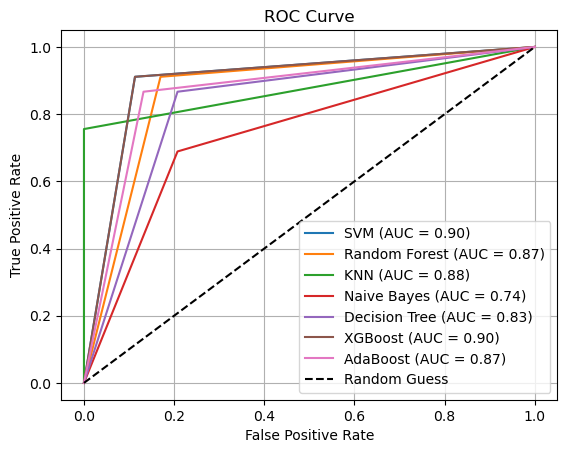

SVM Performance Metrics:
Accuracy: 0.8979591836734694
Precision: 0.8723404255319149
Recall: 0.9111111111111111
F1 Score: 0.891304347826087
AUC-ROC: 0.8989517819706498
Time: 1.7173187732696533

Random Forest Performance Metrics:
Accuracy: 0.8673469387755102
Precision: 0.82
Recall: 0.9111111111111111
F1 Score: 0.8631578947368421
AUC-ROC: 0.870649895178197
Time: 111.14411067962646

KNN Performance Metrics:
Accuracy: 0.8877551020408163
Precision: 1.0
Recall: 0.7555555555555555
F1 Score: 0.8607594936708861
AUC-ROC: 0.8777777777777778
Time: 1.8620405197143555

Naive Bayes Performance Metrics:
Accuracy: 0.7448979591836735
Precision: 0.7380952380952381
Recall: 0.6888888888888889
F1 Score: 0.7126436781609196
AUC-ROC: 0.7406708595387841
Time: 0.3562042713165283

Decision Tree Performance Metrics:
Accuracy: 0.826530612244898
Precision: 0.78
Recall: 0.8666666666666667
F1 Score: 0.8210526315789474
AUC-ROC: 0.829559748427673
Time: 3.1641862392425537

XGBoost Performance Metrics:
Accuracy: 0.89795918

In [111]:
results_female = evaluate_classifiers(X_train_female, y_train_female, X_test_female, y_test_female,'FemaleWithSmoteNormCorrPca')

    
for clf_name, metrics in results_female.items():
    print(clf_name + " Performance Metrics:")
    print("Accuracy:", metrics['accuracy'])
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1 Score:", metrics['f1'])
    print("AUC-ROC:", metrics['auc'])
    print("Time:", metrics['time_execution'])
    print()

Model for SVM saved.
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        64
           1       0.98      0.91      0.94        65

    accuracy                           0.95       129
   macro avg       0.95      0.95      0.95       129
weighted avg       0.95      0.95      0.95       129

[[63  1]
 [ 6 59]]
Model for Random Forest saved.
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94        64
           1       0.95      0.92      0.94        65

    accuracy                           0.94       129
   macro avg       0.94      0.94      0.94       129
weighted avg       0.94      0.94      0.94       129

[[61  3]
 [ 5 60]]
Model for KNN saved.
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        64
           1       1.00

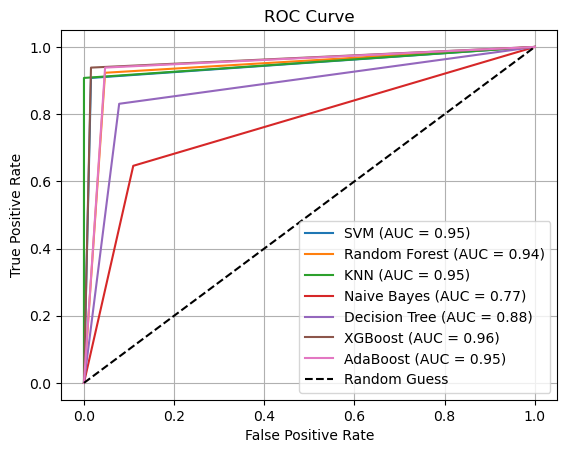

SVM Performance Metrics:
Accuracy: 0.9457364341085271
Precision: 0.9833333333333333
Recall: 0.9076923076923077
F1 Score: 0.944
AUC-ROC: 0.9460336538461538
Time: 2.740708589553833

Random Forest Performance Metrics:
Accuracy: 0.937984496124031
Precision: 0.9523809523809523
Recall: 0.9230769230769231
F1 Score: 0.9375
AUC-ROC: 0.9381009615384616
Time: 146.35770225524902

KNN Performance Metrics:
Accuracy: 0.9534883720930233
Precision: 1.0
Recall: 0.9076923076923077
F1 Score: 0.9516129032258065
AUC-ROC: 0.9538461538461538
Time: 1.7855360507965088

Naive Bayes Performance Metrics:
Accuracy: 0.7674418604651163
Precision: 0.8571428571428571
Recall: 0.6461538461538462
F1 Score: 0.736842105263158
AUC-ROC: 0.768389423076923
Time: 0.276904821395874

Decision Tree Performance Metrics:
Accuracy: 0.875968992248062
Precision: 0.9152542372881356
Recall: 0.8307692307692308
F1 Score: 0.870967741935484
AUC-ROC: 0.8763221153846155
Time: 4.525326251983643

XGBoost Performance Metrics:
Accuracy: 0.961240310

In [112]:
results_male = evaluate_classifiers(X_train_male, y_train_male, X_test_male, y_test_male,'MaleWithSmoteNormCorrPca')

for clf_name, metrics in results_male.items():
    print(clf_name + " Performance Metrics:")
    print("Accuracy:", metrics['accuracy'])
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1 Score:", metrics['f1'])
    print("AUC-ROC:", metrics['auc'])
    print("Time:", metrics['time_execution'])
    print()

In [114]:
results_female['SVM']

{'accuracy': 0.8979591836734694,
 'precision': 0.8723404255319149,
 'recall': 0.9111111111111111,
 'f1': 0.891304347826087,
 'auc': 0.8989517819706498,
 'time_execution': 1.7173187732696533,
 'best_params': {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}}

In [115]:
results_male['SVM']

{'accuracy': 0.9457364341085271,
 'precision': 0.9833333333333333,
 'recall': 0.9076923076923077,
 'f1': 0.944,
 'auc': 0.9460336538461538,
 'time_execution': 2.740708589553833,
 'best_params': {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}}